This script will take the DAVs that are flanking 100 bp of ISREs and fold the sequence around the DAV. 

Then it will use SNPFold and RNAsnp to find DAVs that are altering the local folding landscape. 

Specifically look for ones that altering the base pairing probability of ISREs themselves. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [52]:
numBasesToFold = 100

In [ ]:
%%script bash
# First we need to combine the files for HGMD Muts and ClinVar Muts and sort them
cat ../temp/HGMD/HGMDMuts_Flanking_100bpISREs.txt ../temp/ClinVar/ClinVarMuts_Flanking_100bpISREs.txt > ../temp/Muts_Flanking_100bpISREs.txt
sort -k6,6 -k7,7n -k8,8n ../temp/Muts_Flanking_100bpISREs.txt > ../temp/Muts_Flanking_100bpISREs_Sorted.txt

In [ ]:
# First we have to grab the coordinates +/- 100 base pairs of these mutations and write to file. 
muts = pd.read_table('../temp/Muts_Flanking_100bpISREs_Sorted.txt',sep="\t",header=None)
print muts.head()
muts_newdata = {"chrm":muts[5],"start":muts[6]-(numBasesToFold/2),"end":muts[7]+(numBasesToFold/2),"snp_id":muts[8],"strand":muts[9],"score":[0]*len(muts[8])}
muts_newdf = pd.DataFrame(muts_newdata,columns=["chrm","start","end","snp_id","score","strand"]).drop_duplicates()
print muts_newdf.head()
muts_newdf.to_csv("../temp/Muts_Flanking_100bpISREs_" + str(numBasesToFold) + "bpwindow.txt",header=False,index=False,sep="\t")

In [ ]:
%%script bash
numbases=100
# Get the sequences for that file 
bedtools getfasta -fi /home/shared/hg38/hg38.fa -bed ../temp/Muts_Flanking_100bpISREs_${numbases}bpwindow.txt -name -s -tab -fo ../temp/Muts_Flanking_100bpISREs_${numbases}bpwindow-Sequences.txt

In [ ]:
import subprocess
# This function will run SNPfold on every mutation and write a file that contains the results with the mutation information
# It requires a file that contains sequences around mutation, a file containing info of the WT base and MUT base
def runSNPFold(mutseqfile, mutfile, baseOfinterest,writefile):
    
    # Read the file containing sequences around mutation
    mutseqfile = pd.read_table(mutseqfile,sep="\t",header=None)
    # Create a dictionary for those sequences using the mutation id as key
    mutseq_dict = pd.Series(mutseqfile[1].values,index=mutseqfile[0].values).to_dict()
    
    # Read the file containing information about WT base and MUT base
    mutfile = pd.read_table(mutfile,sep="\t",header=None).iloc[:,range(5,13)].drop_duplicates()
    print mutfile.head()
    # Create a dictionary for strand, WT base and MUT base using the mutation id as key
    mut_dict = {row[8]:[row[9],row[10],row[11]] for index, row in mutfile.iterrows()} 
    #pd.Series(mutfile.iloc[:,[4,5,6]].values,index=mutfile[8].values).to_dict()

    # Dictionary for complementary base dictionary
    base_dict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
    
    # Go through every mutation and run SNPFold on it, the accurate version and write results to file
    with open(writefile, "w") as fw:
        # First write header
        fw.write("MUT" + "\t" + "CC_BPPROB" + "\t" + "CC_BPPROB_PVAL" + "\t" + "CC_SHANNON" + "\t" + "CC_SHANNON_PVAL")
        fw.write("\n")
        # Go through every mutation
        for mut in mut_dict.keys():
            # Get the sequence and bases for the mutation
            seq4mut = mutseq_dict[mut]
            bases4mut = mut_dict[mut]
            # If the mutation is on the negative strand, get the complement of the WT and MUT base
            # Else just get the WT and MUT base
            if bases4mut[0]=="-":
                WTbase=base_dict[bases4mut[1]]
                MUTbase=base_dict[bases4mut[2]]
            else:
                WTbase=bases4mut[1]
                MUTbase=bases4mut[2]
            # Call SNP fold and write result into file    
            pipe_out = subprocess.check_output(["SNPfold_commandline.py","-m","all","-n",mut,"-A", seq4mut, WTbase + baseOfinterest + MUTbase])
            snpfold_for_mut = [i.split('\t') for i in pipe_out.strip().split('\n')][1]
            fw.write(mut + "\t" + "\t".join(snpfold_for_mut[1:]))
            fw.write("\n")

In [ ]:
# Run function 
#runSNPFold("../temp/Muts_Flanking_100bpISREs_"+str(numBasesToFold)+"bpwindow-Sequences.txt","../temp/Muts_Flanking_100bpISREs_Sorted.txt",str((numBasesToFold/2)+1),"../temp/Muts_Flanking_100bpISREs_"+str(numBasesToFold)+"bpwindow_SNPFoldResults.txt")

In [53]:
# Read in SNPFold data
SNPfold_data = pd.read_table("../temp/Muts_Flanking_100bpISREs_"+str(numBasesToFold)+"bpwindow_SNPFoldResults.txt",sep="\t",header=0)
print SNPfold_data.shape
SNPfold_data.head()

(22268, 5)


,MUT,CC_BPPROB,CC_BPPROB_PVAL,CC_SHANNON,CC_SHANNON_PVAL
0,465460,0.678471,0.10526,0.690041,0.13816
1,228057,0.995841,0.93421,0.970579,0.91118
2,378465,0.998228,0.87500,0.977722,0.80921
3,378462,0.862681,0.39474,0.825546,0.49013
4,427285,0.952034,0.44737,0.899208,0.56908


(0, 0.8]       5389
(0.8, 0.9]     3902
(0.9, 0.95]    3859
(0.95, 1]      9111
dtype: int64


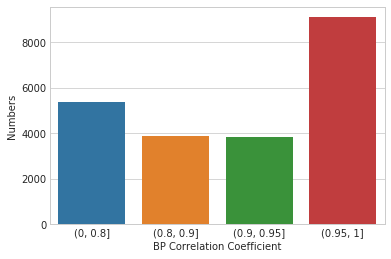

In [54]:
# Plot correlation coefficient data as bar plot
corr_data = SNPfold_data["CC_BPPROB"]
corr_data_breakdown = pd.cut(np.array(corr_data),bins=[0,0.8,0.9,0.95,1])
corr_data_breakdown_freq = corr_data_breakdown.value_counts()
print corr_data_breakdown_freq
counts_df = pd.DataFrame({"Numbers":corr_data_breakdown_freq.values,"BP Correlation Coefficient":corr_data_breakdown_freq.index.values},columns=["BP Correlation Coefficient","Numbers"])
sns.set_style("whitegrid")
ax = sns.barplot(x="BP Correlation Coefficient",y="Numbers",data=counts_df)
plt.show()

In [55]:
# Grab the mutations that result in correlation less than 0.8
SNPfold_data_lowCC = SNPfold_data[SNPfold_data["CC_BPPROB"]<=0.8]
print SNPfold_data_lowCC.shape
SNPfold_data_lowCC.head()

(5396, 5)


,MUT,CC_BPPROB,CC_BPPROB_PVAL,CC_SHANNON,CC_SHANNON_PVAL
0,465460,0.678471,0.10526,0.690041,0.13816
5,378460,0.673778,0.16776,0.870998,0.57237
7,287149,0.685392,0.16776,0.356607,0.08224
10,82448,0.787902,0.53289,0.822089,0.54276
11,CM095436,0.770476,0.09539,0.658545,0.11513


In [58]:
# We want a function that will go through the list of mutations that result in low BP CC and grab ones that change
# the BP of ISREs nearby 
def getMutsAlterISRE_BP(ISREmutfile,SNPfoldfile,cc_cutoff,foldingdist):
    print foldingdist
    # These are the lists that will contain the muts that have an ISRE nearby that changes BP probability or NOT
    muts_StrucISRE_changes =[]
    muts_StrucISRE_DontChange =[]
    # Dictionary for complementary base dictionary
    base_dict = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
    # Read the ISREs near Muts file
    ISREs_nearMuts = pd.read_table(ISREmutfile,sep="\t",header=None)
    # Read the SNPFold results file
    SNPfold_results = pd.read_table(SNPfoldfile,sep="\t",header=0)
    # Get the muts that results in CC of BP to be less than the cut-off
    SNPfold_lowCC = SNPfold_results[SNPfold_results["CC_BPPROB"]<=cc_cutoff]
    # Go through every mutation
    for mut in SNPfold_lowCC["MUT"].values:
        # Get all the ISREs for the Mut
        ISREs_for_Mut = ISREs_nearMuts[ISREs_nearMuts[8]==mut]
        # Get the base probability file for the mut
        #bp_for_Mut = pd.read_table("../scripts/output/"+mut+'_'+str(foldingdist+1)+"/input_mutations_bpProbs_perNt.txt",sep="\t",header=None)
        bp_for_Mut = pd.read_table("../scripts/output/"+mut+"/input_mutations_bpProbs_perNt.txt",sep="\t",header=None)
        # Get the mutation for the MUT id, this so that we can get the right row from bpProbabilities table
        if ISREs_for_Mut.iloc[0,9]=="-":
            WTbase=base_dict[ISREs_for_Mut.iloc[0,10]]
            MUTbase=base_dict[ISREs_for_Mut.iloc[0,11]]
        else:
            WTbase=ISREs_for_Mut.iloc[0,10]
            MUTbase=ISREs_for_Mut.iloc[0,11]
        if WTbase=="T":
            WTbase="U"
        if MUTbase=="T":
            MUTbase="U"
        # Get only the WT row and the mutant row
        WT_bp = bp_for_Mut[bp_for_Mut[0]=="WT"]
        MUT_bp = bp_for_Mut[bp_for_Mut[0]==(WTbase+str(foldingdist+1)+MUTbase)]
        # This keeps count of how many ISREs that have changes in bp probs 
        numISREs_Mut = 0
        # Go through every ISRE for Mut and get the base pairing probabilities for WT seq and MUT seq for ISRE
        # If the location of ISRE is less than 6 bases away from the start and end of the seq
        # then reduce the number of bases we look at for that ISRE
        for index,row in ISREs_for_Mut.iterrows():
            ISRE = row[3]
            # If minus strand, the ISRE coordinates are flipped, the start coordinate is actually the end coordinate
            # And if ISRE coordinate is greater than mut, it is actually on the left of the Mut instead of the right 
            # of the mut
            if row[9] == "-":
                ISRE_dist_from_Mut = row[1]+50+5 - row[6]
                start_index_for_ISRE = foldingdist+1 - ISRE_dist_from_Mut
            else:
                ISRE_dist_from_Mut = row[1]+50 - row[6]
                start_index_for_ISRE = foldingdist+1 + ISRE_dist_from_Mut
            if start_index_for_ISRE > (2*foldingdist)-4:
                bpProb_WT = WT_bp.iloc[0,range(start_index_for_ISRE,(2*foldingdist)+2)]
                bpProb_MUT = MUT_bp.iloc[0,range(start_index_for_ISRE,(2*foldingdist)+2)]
            elif start_index_for_ISRE < 6:
                bpProb_WT = WT_bp.iloc[0,range(1,start_index_for_ISRE+1)]
                bpProb_MUT = MUT_bp.iloc[0,range(1,start_index_for_ISRE+1)]
            else:
                bpProb_WT = WT_bp.iloc[0,range(start_index_for_ISRE,start_index_for_ISRE+6)]
                bpProb_MUT = MUT_bp.iloc[0,range(start_index_for_ISRE,start_index_for_ISRE+6)]
            # Number of bases for ISRE whose bp probability differs greater than 0.5 between WT and MUT seq
            Diffs = [i for i in bpProb_WT-bpProb_MUT if abs(i)>=0.5]
            if len(Diffs)>0:
                muts_StrucISRE_changes.append([mut,ISRE,ISRE_dist_from_Mut,len(Diffs)])
                numISREs_Mut += 1
        # Check if no ISREs have bp probability changes between WT and MUT seq, then add MUT to dont change list
        if numISREs_Mut == 0 :
            muts_StrucISRE_DontChange.append(mut)
    return muts_StrucISRE_changes,muts_StrucISRE_DontChange

In [59]:
# Use a correlation coefficient of 1 to look for all mutations regardless of how they change local structure
# We just want to grab any Muts that are altering ISRE bp Probabilities 
muts_altering_ISREbpProb,muts_NOTaltering_ISREbpProb = getMutsAlterISRE_BP("../temp/Muts_Flanking_100bpISREs_Sorted.txt","../temp/Muts_Flanking_100bpISREs_"+str(numBasesToFold)+"bpwindow_SNPFoldResults.txt",1,numBasesToFold/2)

50


Number of DAVs altering ISRE bp Probability:  4688
Number of DAVs NOT altering ISRE bp Probability:  17579


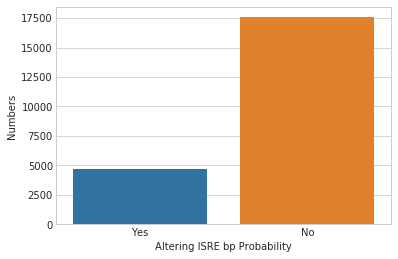

In [27]:
# Get the numbers of MUTs altering base pairing probability and plot as bar plot
actualMuts_altering_ISREbpProb = list(set([i[0] for i in muts_altering_ISREbpProb]))
print "Number of DAVs altering ISRE bp Probability: ", len(actualMuts_altering_ISREbpProb)
print "Number of DAVs NOT altering ISRE bp Probability: ", len(muts_NOTaltering_ISREbpProb)
counts_df = pd.DataFrame({"Numbers":[len(actualMuts_altering_ISREbpProb),len(muts_NOTaltering_ISREbpProb)],"Altering ISRE bp Probability":["Yes","No"]},columns=["Altering ISRE bp Probability","Numbers"])
sns.set_style("whitegrid")
ax = sns.barplot(x="Altering ISRE bp Probability",y="Numbers",data=counts_df)
plt.show()

In [28]:
# Write the mutations that are altering ISRE base pairing probability into a file
pd.DataFrame(muts_altering_ISREbpProb).to_csv("../temp/Muts_Flanking_100bpISREs_"+str(numBasesToFold)+"bpwindow_AlteringISREbpProb.txt",sep="\t",header=False,index=False)

In [29]:
# Seperate out by ClinVar and HGMD mutations
ClinVar_muts_altering_ISREbpProb = [i for i in muts_altering_ISREbpProb if i[0].isdigit()]
print "Number of ClinVar muts altering ISRE probability: ", len(ClinVar_muts_altering_ISREbpProb)
HGMD_muts_altering_ISREbpProb = [i for i in muts_altering_ISREbpProb if ~i[0].isdigit()]
print "Number of HGMD muts altering ISRE probability: ", len(HGMD_muts_altering_ISREbpProb)

Number of ClinVar muts altering ISRE probability:  8125
Number of HGMD muts altering ISRE probability:  10180


In [30]:
# Get details about the HGMD mutations
all_hgmd_muts = pd.read_csv("../processed_data/HGMD_PRO_2016.3_hg38.bed", sep="\t",header=None,low_memory=False)
hgmd_muts_relevent = all_hgmd_muts[all_hgmd_muts[3].isin([i[0] for i in HGMD_muts_altering_ISREbpProb])]
print hgmd_muts_relevent.shape
hgmd_muts_relevent.head()

(1008, 9)


,0,1,2,3,4,5,6,7,8
299,1,8957144,8957145,CM065045,.,A,G,.,CLASS=DP;MUT=ALT;GENE=CA6;STRAND=+;DNA=NM_0012...
903,1,15505999,15506000,CM156160,.,T,G,.,CLASS=DM?;MUT=ALT;GENE=CASP9;STRAND=-;DNA=NM_0...
1455,1,21561137,21561138,CM980058,.,G,A,.,CLASS=DM;MUT=ALT;GENE=ALPL;STRAND=+;DNA=NM_000...
2123,1,25306615,25306616,CS158952,.,G,A,.,CLASS=FP;MUT=ALT;GENE=RHD;STRAND=+;DNA=NM_0161...
2124,1,25306623,25306624,CM158949,.,C,T,.,CLASS=FP;MUT=ALT;GENE=RHD;STRAND=+;DNA=NM_0161...


In [31]:
# We want to merge the HGMD data together: the info about the mutation and how mutation is affecting ISREs
HGMD_muts_altering_ISREbpProb_DF = pd.DataFrame(HGMD_muts_altering_ISREbpProb)
HGMD_muts_altering_ISREbpProb_DF.head()
combined_HGMD_data = HGMD_muts_altering_ISREbpProb_DF.merge(hgmd_muts_relevent,left_on=0,right_on=3)
combined_HGMD_data['0_y'] = 'chr' + combined_HGMD_data['0_y'].astype(str)
print combined_HGMD_data.shape
combined_HGMD_data.head()

(2055, 14)


,0,0_x,1_x,2_x,3_x,0_y,1_y,2_y,3_y,4,5,6,7,8
0,CM095436,CM095436,AGGGTT,-26,3,chr5,70076544,70076545,CM095436,.,G,C,.,CLASS=DM;MUT=ALT;GENE=SMN2;STRAND=+;DNA=NM_017...
1,CM095436,CM095436,GGGTTT,-25,3,chr5,70076544,70076545,CM095436,.,G,C,.,CLASS=DM;MUT=ALT;GENE=SMN2;STRAND=+;DNA=NM_017...
2,CM095436,CM095436,GGTTTT,-24,2,chr5,70076544,70076545,CM095436,.,G,C,.,CLASS=DM;MUT=ALT;GENE=SMN2;STRAND=+;DNA=NM_017...
3,CM095436,CM095436,TTTAGA,-21,4,chr5,70076544,70076545,CM095436,.,G,C,.,CLASS=DM;MUT=ALT;GENE=SMN2;STRAND=+;DNA=NM_017...
4,CM134391,CM134391,AGGAAC,1,1,chrX,2877253,2877254,CM134391,.,C,T,.,CLASS=DM?;MUT=ALT;GENE=GYG2;STRAND=+;DNA=NM_00...


In [35]:
# Write HGMD data to a file
combined_HGMD_data.iloc[:,range(1,14)].to_csv("../processed_data/Putative_RiboSPLitches_HGMDMuts_"+str(numBasesToFold)+"bpwindow.txt",sep="\t",header=False,index=False)

In [36]:
# Get details about the ClinVar mutations
all_clinvar_muts = pd.read_csv("../processed_data/clinvar.bed",sep="\t",header=None,low_memory=False)
# Get the clinvar mutations
clinvar_muts_relevent = all_clinvar_muts[all_clinvar_muts[3].isin([int(i[0]) for i in ClinVar_muts_altering_ISREbpProb])]
print clinvar_muts_relevent.shape
clinvar_muts_relevent.head()

(3680, 9)


,0,1,2,3,4,5,6,7,8
154,1,1050053,1050054,263190,.,T,A,.,AF_EXAC=0.00051;AF_TGP=0.0016;ALLELEID=249340;...
445,1,2303416,2303417,258899,.,C,T,.,AF_EXAC=0.00001;ALLELEID=249763;CLNDISDB=MedGe...
615,1,2559360,2559361,133401,.,G,T,.,ALLELEID=137140;CLNDISDB=MedGen:CN169374;CLNDN...
620,1,2559502,2559503,133406,.,C,A,.,ALLELEID=137145;CLNDISDB=MedGen:CN169374;CLNDN...
627,1,2559724,2559725,133413,.,G,A,.,AF_EXAC=0.01977;AF_TGP=0.0116;ALLELEID=137152;...


In [37]:
# We want to merge the Clin Var data together: the info about the mutation and how mutation is affecting ISREs
ClinVar_muts_altering_ISREbpProb_DF = pd.DataFrame(ClinVar_muts_altering_ISREbpProb)
ClinVar_muts_altering_ISREbpProb_DF[0] = ClinVar_muts_altering_ISREbpProb_DF[0].apply(int)
ClinVar_muts_altering_ISREbpProb_DF.head()
combined_ClinVar_data = ClinVar_muts_altering_ISREbpProb_DF.merge(clinvar_muts_relevent,left_on=0,right_on=3)
combined_ClinVar_data['0_y'] = 'chr' + combined_ClinVar_data['0_y'].astype(str)
print combined_ClinVar_data.shape
combined_ClinVar_data.head()

(8125, 14)


,0,0_x,1_x,2_x,3_x,0_y,1_y,2_y,3_y,4,5,6,7,8
0,228050,228050,AGGTAA,14,1,chr21,44504766,44504767,228050,.,G,A,.,AF_EXAC=0.00003;ALLELEID=231377;CLNDISDB=MedGe...
1,260298,260298,GGGAGG,-12,1,chr14,77279773,77279774,260298,.,G,A,.,AF_ESP=0.0440;AF_EXAC=0.05999;AF_TGP=0.0184;AL...
2,195517,195517,AGGTAA,8,1,chr17,10533501,10533502,195517,.,A,C,.,AF_ESP=0.0002;AF_EXAC=0.00093;ALLELEID=192678;...
3,392112,392112,GAGTGT,-14,1,chr12,98593756,98593757,392112,.,C,A,.,ALLELEID=372600;CLNDISDB=MedGen:CN169374;CLNDN...
4,392112,392112,AGTGTG,-13,1,chr12,98593756,98593757,392112,.,C,A,.,ALLELEID=372600;CLNDISDB=MedGen:CN169374;CLNDN...


In [38]:
# Write ClinVar data to a file
combined_ClinVar_data.iloc[:,range(1,14)].to_csv("../processed_data/Putative_RiboSPLitches_ClinVarMuts_"+str(numBasesToFold)+"bpwindow.txt",sep="\t",header=False,index=False)

In [39]:
# These are motifs that were tested in Wang et al 2012 papers for ISREs motifs
ISE_motifs = ['GGGTTT','GGTGGT','TTTGGG','GAGGGG','GGTATT','GTAACG']
ISS_motifs = ['CTCCTC','CTTCAG','GAACAG','ACATGA','AATTTA','AGTAGG','TACAGC','ACAGCT','CAAAGG','AGATAT']
ISRE_motifs = ISE_motifs + ISS_motifs

In [40]:
# Get mutations that alter ISRE motif bp Probabilities of motifs tested by Wang et al 2012 for HGMD mutations
combined_HGMD_data_testedISREs = combined_HGMD_data[combined_HGMD_data['1_x'].isin(ISRE_motifs)]
print combined_HGMD_data_testedISREs.shape
combined_HGMD_data_testedISREs.head()

(247, 14)


,0,0_x,1_x,2_x,3_x,0_y,1_y,2_y,3_y,4,5,6,7,8
1,CM095436,CM095436,GGGTTT,-25,3,chr5,70076544,70076545,CM095436,.,G,C,.,CLASS=DM;MUT=ALT;GENE=SMN2;STRAND=+;DNA=NM_017...
13,CM151562,CM151562,TTTGGG,-42,4,chr4,13369887,13369888,CM151562,.,A,C,.,CLASS=DM;MUT=ALT;GENE=RAB28;STRAND=-;DNA=NM_00...
21,CM000206,CM000206,CTTCAG,-9,4,chr11,112087915,112087916,CM000206,.,C,T,.,CLASS=DM;MUT=ALT;GENE=SDHD;STRAND=+;DNA=NM_003...
27,CM143109,CM143109,GGTGGT,-38,2,chr7,6006002,6006003,CM143109,.,T,C,.,CLASS=DM?;MUT=ALT;GENE=PMS2;STRAND=-;DNA=NM_00...
47,CM162842,CM162842,AGATAT,-16,2,chr14,87988492,87988493,CM162842,.,C,T,.,CLASS=DM;MUT=ALT;GENE=GALC;STRAND=-;DNA=NM_000...


In [41]:
# Sort by the absolute value of the column that indicates how far ISRE is from mutation and write a file
combined_HGMD_data_testedISREs.reindex(combined_HGMD_data_testedISREs['2_x'].abs().sort_values().index).iloc[:,range(1,14)].to_csv("../processed_data/Putative_RiboSPLitches_HGMDMuts_ISREMotifsTested_"+str(numBasesToFold)+"bpwindow.txt",sep="\t",header=False,index=False)

In [42]:
# Get mutations that alter ISRE motif bp Probabilities of motifs tested by Wang et al 2012 for ClinVar mutations
combined_ClinVar_data_testedISREs = combined_ClinVar_data[combined_ClinVar_data['1_x'].isin(ISRE_motifs)]
print combined_ClinVar_data_testedISREs.shape
combined_ClinVar_data_testedISREs.head()

(878, 14)


,0,0_x,1_x,2_x,3_x,0_y,1_y,2_y,3_y,4,5,6,7,8
33,256124,256124,GAGGGG,-18,3,chr19,15187085,15187086,256124,.,C,T,.,ALLELEID=256818;CLNDISDB=MedGen:CN169374;CLNDN...
35,290485,290485,GGGTTT,-9,2,chr1,46192508,46192509,290485,.,C,G,.,AF_EXAC=0.00003;ALLELEID=274722;CLNDISDB=MedGe...
62,258492,258492,GAGGGG,4,1,chr2,219420459,219420460,258492,.,C,A,.,AF_ESP=0.0378;AF_EXAC=0.03629;AF_TGP=0.0128;AL...
72,264905,264905,CAAAGG,-22,1,chr13,32321611,32321612,264905,.,G,C,.,AF_TGP=0.0056;ALLELEID=259415;CLNDISDB=MedGen:...
83,191142,191142,CTCCTC,-24,3,chr2,178721980,178721981,191142,.,T,C,.,ALLELEID=188945;CLNDISDB=MedGen:CN517202;CLNDN...


In [43]:
# Sort by the absolute value of the column that indicates how far ISRE is from mutation and write a file
combined_ClinVar_data_testedISREs.reindex(combined_ClinVar_data_testedISREs['2_x'].abs().sort_values().index).iloc[:,range(1,14)].to_csv("../processed_data/Putative_RiboSPLitches_ClinVarMuts_ISREMotifsTested_"+str(numBasesToFold)+"bpwindow.txt",sep="\t",header=False,index=False)

In [44]:
%%script bash
# Let's grab mutations that are not within the introns
bedtools intersect -a ../processed_data/CombinedMutations_HGMDandClinVar.bed -b ../processed_data/Introns_DoNotIntersect_Exons.bed -wa > ../temp/CombinedMutations_HGMDandClinVar_Intersect_Introns_DoNotIntersect_Exons.bed

In [45]:
# Read in the file that contains the mutations that are intersecting introns that are NOT intersecting any exons
muts_Intersect_Introns_DontIntersect_Exons = pd.read_table("../temp/CombinedMutations_HGMDandClinVar_Intersect_Introns_DoNotIntersect_Exons.bed",sep="\t",header=None)
print muts_Intersect_Introns_DontIntersect_Exons.shape
muts_Intersect_Introns_DontIntersect_Exons.head()

(124737, 7)


,0,1,2,3,4,5,6
0,chr1,1022187,1022188,263166,A,G,Benign
1,chr1,1022187,1022188,263166,A,G,Benign
2,chr1,1041949,1041950,128292,T,C,Benign
3,chr1,1041949,1041950,128292,T,C,Benign
4,chr1,1042189,1042190,263159,G,A,Benign


In [46]:
# Lets get HGMD muts that are putative RiboSPLitches that do not intersect exons
combined_HGMD_data_NoIntersectExons = combined_HGMD_data[combined_HGMD_data[0].isin(muts_Intersect_Introns_DontIntersect_Exons[3])]
print combined_HGMD_data_NoIntersectExons.shape
combined_HGMD_data_NoIntersectExons.iloc[:,range(1,14)].to_csv("../processed_data/Putative_RiboSPLitches_HGMDMuts_DoNotIntersectExons_"+str(numBasesToFold)+"bpwindow.txt",sep="\t",header=False,index=False)
combined_HGMD_data_NoIntersectExons.head()

(276, 14)


,0,0_x,1_x,2_x,3_x,0_y,1_y,2_y,3_y,4,5,6,7,8
8,CS083955,CS083955,GGTGGG,3,1,chr1,247444845,247444846,CS083955,.,C,T,.,CLASS=DM?;MUT=ALT;GENE=NLRP3;STRAND=+;DNA=NM_0...
26,CS045477,CS045477,GGTTTG,-13,4,chr22,29636748,29636749,CS045477,.,A,C,.,CLASS=DM;MUT=ALT;GENE=NF2;STRAND=+;DNA=NM_0002...
32,CS064464,CS064464,TTGGTG,42,1,chr16,31093187,31093188,CS064464,.,C,G,.,CLASS=DP;MUT=ALT;GENE=VKORC1;STRAND=-;DNA=NM_0...
41,CS1510471,CS1510471,AGAGGT,2,3,chr11,68049425,68049426,CS1510471,.,T,C,.,CLASS=DM;MUT=ALT;GENE=TCIRG1;STRAND=+;DNA=NM_0...
51,CS1511525,CS1511525,AGATAG,14,1,chrX,154933356,154933357,CS1511525,.,A,T,.,CLASS=DM?;MUT=ALT;GENE=F8;STRAND=-;DNA=NM_0001...


In [47]:
# Lets get HGMD muts that are putative RiboSPLitches that are for tested ISREs that do not intersect exons
combined_HGMD_data_testedISREs_NoIntersectExons = combined_HGMD_data_testedISREs[combined_HGMD_data_testedISREs[0].isin(muts_Intersect_Introns_DontIntersect_Exons[3])]
print combined_HGMD_data_testedISREs_NoIntersectExons.shape
combined_HGMD_data_testedISREs_NoIntersectExons.head()

(29, 14)


,0,0_x,1_x,2_x,3_x,0_y,1_y,2_y,3_y,4,5,6,7,8
147,CS033832,CS033832,GGGTTT,-38,2,chr17,43047634,43047635,CS033832,.,C,A,.,CLASS=DM?;MUT=ALT;GENE=BRCA1;STRAND=-;DNA=NM_0...
184,CR104260,CR104260,CTCCTC,24,4,chr4,15938607,15938608,CR104260,.,C,A,.,CLASS=DFP;MUT=ALT;GENE=FGFBP1;STRAND=-;DB=rs12...
277,CR1111332,CR1111332,CTCCTC,7,1,chr14,53955198,53955199,CR1111332,.,G,C,.,CLASS=DP;MUT=ALT;GENE=BMP4;STRAND=-;DB=rs28555...
279,CR1111332,CR1111332,ACAGCT,45,1,chr14,53955198,53955199,CR1111332,.,G,C,.,CLASS=DP;MUT=ALT;GENE=BMP4;STRAND=-;DB=rs28555...
286,CS1514361,CS1514361,GAGGGG,-30,2,chr1,155023026,155023027,CS1514361,.,G,A,.,CLASS=FP;MUT=ALT;GENE=DCST2;STRAND=-;DNA=NM_14...


In [48]:
# Sort by the absolute value of the column that indicates how far ISRE is from mutation and write a file
combined_HGMD_data_testedISREs_NoIntersectExons.reindex(combined_HGMD_data_testedISREs_NoIntersectExons['2_x'].abs().sort_values().index).iloc[:,range(1,14)].to_csv("../processed_data/Putative_RiboSPLitches_HGMDMuts_ISREMotifsTested_DoNotIntersectExons_"+str(numBasesToFold)+"bpwindow.txt",sep="\t",header=False,index=False)

In [49]:
# Lets get ClinVar muts that are putative RiboSPLitches that do not intersect exons
combined_ClinVar_data_NoIntersectExons = combined_ClinVar_data[combined_ClinVar_data[0].apply(str).isin(muts_Intersect_Introns_DontIntersect_Exons[3])]
print combined_ClinVar_data_NoIntersectExons.shape
combined_ClinVar_data_NoIntersectExons.iloc[:,range(1,14)].to_csv("../processed_data/Putative_RiboSPLitches_ClinVarMuts_DoNotIntersectExons_"+str(numBasesToFold)+"bpwindow.txt",sep="\t",header=False,index=False)
combined_ClinVar_data_NoIntersectExons.head()

(3729, 14)


,0,0_x,1_x,2_x,3_x,0_y,1_y,2_y,3_y,4,5,6,7,8
0,228050,228050,AGGTAA,14,1,chr21,44504766,44504767,228050,.,G,A,.,AF_EXAC=0.00003;ALLELEID=231377;CLNDISDB=MedGe...
1,260298,260298,GGGAGG,-12,1,chr14,77279773,77279774,260298,.,G,A,.,AF_ESP=0.0440;AF_EXAC=0.05999;AF_TGP=0.0184;AL...
2,195517,195517,AGGTAA,8,1,chr17,10533501,10533502,195517,.,A,C,.,AF_ESP=0.0002;AF_EXAC=0.00093;ALLELEID=192678;...
6,392117,392117,GGTAAG,7,3,chr16,23434628,23434629,392117,.,T,G,.,ALLELEID=374221;CLNDISDB=MedGen:CN169374;CLNDN...
7,392117,392117,AGGTAA,8,4,chr16,23434628,23434629,392117,.,T,G,.,ALLELEID=374221;CLNDISDB=MedGen:CN169374;CLNDN...


In [50]:
# Lets get HGMD muts that are putative RiboSPLitches that are for tested ISREs that do not intersect exons
combined_ClinVar_data_testedISREs_NoIntersectExons = combined_ClinVar_data_testedISREs[combined_ClinVar_data_testedISREs[0].apply(str).isin(muts_Intersect_Introns_DontIntersect_Exons[3])]
print combined_ClinVar_data_testedISREs_NoIntersectExons.shape
combined_ClinVar_data_testedISREs_NoIntersectExons.head()

(337, 14)


,0,0_x,1_x,2_x,3_x,0_y,1_y,2_y,3_y,4,5,6,7,8
33,256124,256124,GAGGGG,-18,3,chr19,15187085,15187086,256124,.,C,T,.,ALLELEID=256818;CLNDISDB=MedGen:CN169374;CLNDN...
35,290485,290485,GGGTTT,-9,2,chr1,46192508,46192509,290485,.,C,G,.,AF_EXAC=0.00003;ALLELEID=274722;CLNDISDB=MedGe...
62,258492,258492,GAGGGG,4,1,chr2,219420459,219420460,258492,.,C,A,.,AF_ESP=0.0378;AF_EXAC=0.03629;AF_TGP=0.0128;AL...
72,264905,264905,CAAAGG,-22,1,chr13,32321611,32321612,264905,.,G,C,.,AF_TGP=0.0056;ALLELEID=259415;CLNDISDB=MedGen:...
129,259529,259529,CTCCTC,8,5,chr22,33316046,33316047,259529,.,G,A,.,AF_ESP=0.0071;AF_EXAC=0.00217;AF_TGP=0.0070;AL...


In [51]:
# Sort by the absolute value of the column that indicates how far ISRE is from mutation and write a file
combined_ClinVar_data_testedISREs_NoIntersectExons.reindex(combined_ClinVar_data_testedISREs_NoIntersectExons['2_x'].abs().sort_values().index).iloc[:,range(1,14)].to_csv("../processed_data/Putative_RiboSPLitches_ClinVarMuts_ISREMotifsTested_DoNotIntersectExons_"+str(numBasesToFold)+"bpwindow.txt",sep="\t",header=False,index=False)